## Notebook 01 – Data Exploration

This notebook provides a first look at the [HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) dataset.

We’ll explore:
- Dataset structure and image counts
- Class distributions
- Basic quality checks and metadata inspection

> **Note**: This notebook assumes that the dataset has been downloaded and placed in the following directory:
>
> ```
> data/raw/HAM10000/
> ├── HAM10000_metadata.csv
> ├── images/ISIC_0024306.jpg
> └── images/ISIC_0024307.jpg
> ```



In [36]:
# Standard libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Project paths
PROJECT_DIR = Path.cwd().parents[0]
DATA_RAW = PROJECT_DIR / "data" / "raw" / "HAM10000"
IMAGE_DIR = DATA_RAW / "images"

# Data set location check
assert (DATA_RAW / "HAM10000_metadata.csv").exists() \
   and (IMAGE_DIR / "ISIC_0024306.jpg").exists(), "Metadata or image files not found. Please check dataset location."


In [58]:
metadata = pd.read_csv(DATA_RAW / "HAM10000_metadata.csv")
print(f"Metadata shape: {metadata.shape}")
metadata.head(10)


Metadata shape: (10015, 8)


,lesion_id,image_id,dx,dx_type,age,sex,localization,filename
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,ISIC_0027850.jpg
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,ISIC_0029176.jpg
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,ISIC_0029068.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,ISIC_0025837.jpg
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,ISIC_0025209.jpg


This first glance at the metadata already shows a problem with the dataset: There are duplicate images of the same lesion! Let's deal with that in a moment and have a look at the class distribution first.

## Class Distribution

Let’s examine how many samples exist for each diagnosis category.


/tmp/ipykernel_509556/3143675333.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index,


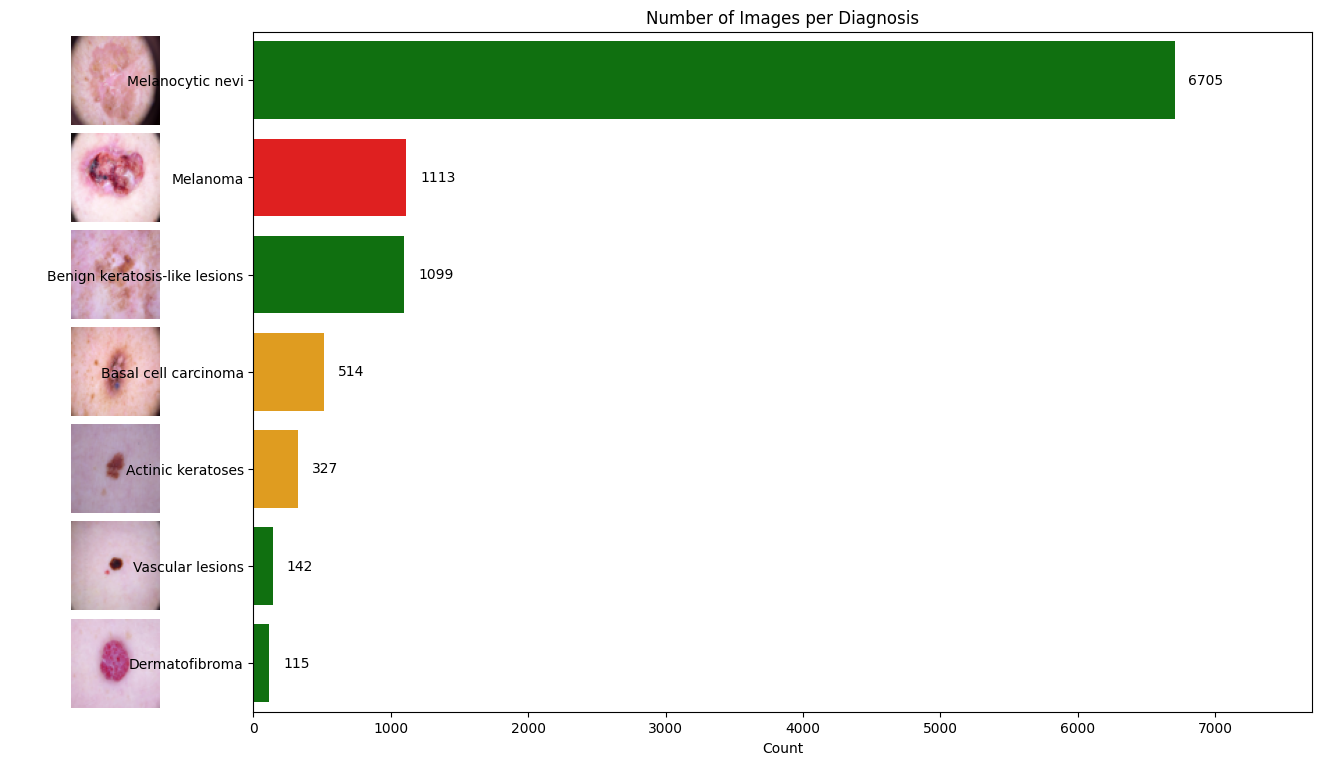

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as gridspec

# Load data and map labels
metadata = pd.read_csv(DATA_RAW / "HAM10000_metadata.csv")
dx_mapping = {
    'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 
    'bkl': 'Benign keratosis-like lesions', 'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses', 'vasc': 'Vascular lesions', 
    'df': 'Dermatofibroma'
}
metadata["dx_full"] = metadata["dx"].map(dx_mapping)

# Get class counts and representative images (just the first one in the table)
counts = metadata["dx_full"].value_counts()
representatives = metadata.groupby("dx_full").first().reset_index()

# Define colors for each category
# Melanoma: red, other malignant (basal cell carcinoma, actinic keratoses): orange, benign: green
colors = []
for category in counts.index:
    if category == 'Melanoma':
        colors.append('red')
    elif category in ['Basal cell carcinoma', 'Actinic keratoses']:
        colors.append('orange')
    else:
        colors.append('green')

# Create figure with two columns
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5], wspace=0.05)
ax_img = fig.add_subplot(gs[0])
ax_img.axis("off")
ax_bar = fig.add_subplot(gs[1], sharey=ax_img)

# Create bar plot with custom colors
sns.barplot(y=counts.index,
            x=counts.values,
            ax=ax_bar,
            palette=colors,
            errorbar=None)
ax_bar.set(title="Number of Images per Diagnosis", xlabel="Count", ylabel="")
ax_bar.set_xlim(0, counts.max() + 1000)

# Add count labels
for i, value in enumerate(counts):
    ax_bar.text(value + 100, i, str(value), va='center')

# Add representative images
for i, (_, row) in enumerate(representatives.iterrows()):
    try:
        img = Image.open(IMAGE_DIR / f"{row['image_id']}.jpg").convert("RGB").resize((64, 64))
        imagebox = OffsetImage(img, zoom=1)
        ab = AnnotationBbox(imagebox, (0.5, i), frameon=False, box_alignment=(0.5, 0.5))
        ax_img.add_artist(ab)
    except FileNotFoundError:
        print(f"Image not found: {row['image_id']}.jpg")

plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.1)
plt.show()

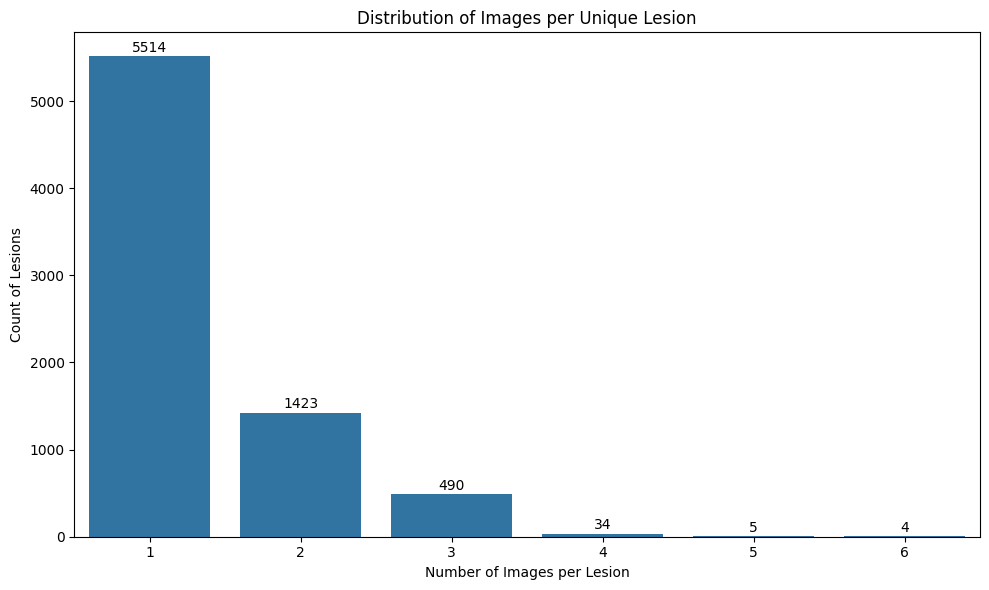

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Count occurrences of each lesion_id
lesion_counts = metadata['lesion_id'].value_counts()

# Create a Series counting how many lesions have 1, 2, 3, etc. images
duplicate_distribution = lesion_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=duplicate_distribution.index, y=duplicate_distribution.values)
plt.xlabel('Number of Images per Lesion')
plt.ylabel('Count of Lesions')
plt.title('Distribution of Images per Unique Lesion')

# Add count labels on top of bars
for i, count in enumerate(duplicate_distribution.values):
    plt.text(i, count + 50, str(count), ha='center')

plt.tight_layout()
plt.show()

So of the 10015 images, about half are of unique lesions, while the rest have at least one duplicate image. Let's look at how lesion duplicates are distributed across classes.

In [82]:
# Code to check the distribution of duplicate lesions across dx classes


# Step 1: Find lesion_ids that have duplicates (more than one image)
duplicate_lesion_ids = metadata['lesion_id'].value_counts()
duplicate_lesion_ids = duplicate_lesion_ids[duplicate_lesion_ids > 1].index

# Step 2: Subset df to only those lesions
df_duplicates = metadata[metadata['lesion_id'].isin(duplicate_lesion_ids)]

# Step 3: Count how many duplicate lesions appear in each dx class
duplicates_per_class = df_duplicates.drop_duplicates('lesion_id')['dx'].value_counts().sort_index()

# Step 4: Count total lesions per class (for normalization)
total_lesions_per_class = metadata.drop_duplicates('lesion_id')['dx'].value_counts().sort_index()

# Step 5: Calculate proportion of lesions with duplicates per class
proportion_with_duplicates = (duplicates_per_class / total_lesions_per_class).sort_index()

# Show results
results_df = pd.DataFrame({
    'Total Lesions': total_lesions_per_class,
    'Duplicate Lesions': duplicates_per_class,
    'Proportion with Duplicates': proportion_with_duplicates
}).fillna(0)

print(results_df)

       Total Lesions  Duplicate Lesions  Proportion with Duplicates
dx                                                                 
akiec            228                 77                    0.337719
bcc              327                152                    0.464832
bkl              727                287                    0.394773
df                73                 34                    0.465753
mel              614                384                    0.625407
nv              5403                988                    0.182861
vasc              98                 34                    0.346939


Fortunately, there doesn't seem to be a a large disparity between classes. Let's have a look at some examples.

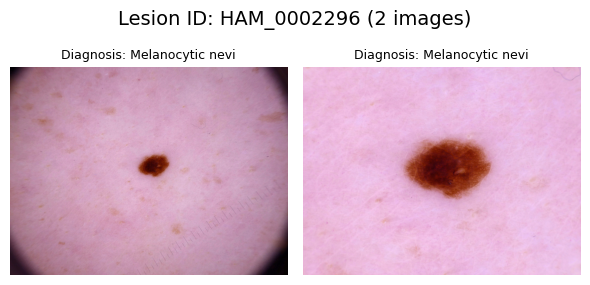

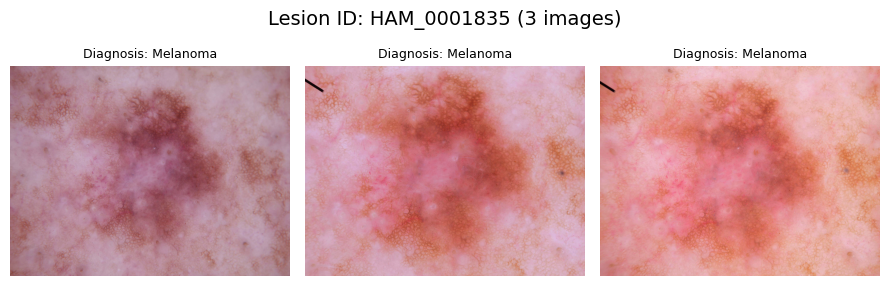

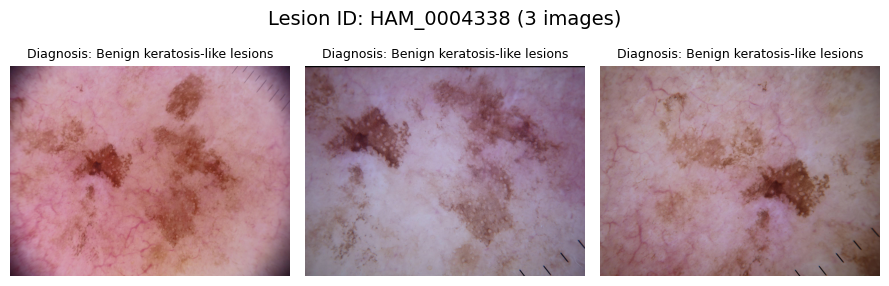

In [81]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random

def plot_duplicate_lesions(df, image_dir, num_to_show=3, seed=None):
    """
    Plot multiple images of the same lesion to visualize duplicates.
    
    Parameters:
    ----------
    df : pandas.DataFrame
        Dataframe containing image metadata with 'lesion_id' and 'filename' columns
    image_dir : str or Path
        Directory containing the images
    num_to_show : int
        Number of different lesions to display
    seed : int, optional
        Random seed for reproducibility
    """
    image_dir = Path(image_dir)
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)

    # Find lesion_ids with duplicates
    lesion_counts = df['lesion_id'].value_counts()
    duplicate_ids = lesion_counts[lesion_counts > 1].index.tolist()
    
    if not duplicate_ids:
        print("No duplicate lesions found in the dataset.")
        return
    
    # Randomly sample lesion_ids
    selected_ids = random.sample(duplicate_ids, min(num_to_show, len(duplicate_ids)))
    
    # Plot each selected lesion's images horizontally
    for lesion_id in selected_ids:
        lesion_df = df[df["lesion_id"] == lesion_id]
        
        # Try-except block to handle potential file loading issues
        try:
            fig, axes = plt.subplots(1, len(lesion_df), figsize=(3 * len(lesion_df), 3))
            
            # Ensure axes is always iterable
            if len(lesion_df) == 1:
                axes = [axes]
            
            fig.suptitle(f"Lesion ID: {lesion_id} ({len(lesion_df)} images)", fontsize=14)
            
            for i, (_, row) in enumerate(lesion_df.iterrows()):
                img = Image.open(image_dir / row["filename"])
                axes[i].imshow(img)
                axes[i].set_title(f"Diagnosis: {row.get('dx_full', row.get('dx', 'Unknown'))}", fontsize=9)
                axes[i].set_xlabel(f"ID: {row['image_id']}", fontsize=8)
                axes[i].axis("off")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error displaying lesion ID {lesion_id}: {e}")

# Usage
plot_duplicate_lesions(metadata, IMAGE_DIR, num_to_show=3, seed=42)

While it is likely that duplicate images of single lesions where taken with a certain time lag (e.g. at different visits at the dermatologist), they are clearly too much alike and would result in data leakage effects during training and testing. Thus, we need to get rid of duplicates from now on. For simplicity, we will keep the first occurence of a lesion in an image and remove all others.

In [83]:
# Remove lesion duplicates from dataset and save new csv file
metadata = pd.read_csv(DATA_RAW / "HAM10000_metadata.csv")
# Drop duplicates by keeping the first image per lesion_id
df_unique_lesions = metadata.drop_duplicates(subset="lesion_id", keep="first")
# Save to CSV file
df_unique_lesions.to_csv(DATA_RAW / "HAM10000_metadata_clean.csv", index=False)

In [86]:
print(f"Final count of images to be used: {df_unique_lesions.shape[0]}")
print("Final distribution of images across classes:")
df_unique_lesions['dx'].value_counts()

Final count of images to be used: 7470
Final distribution of images across classes:


dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64